In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os, sys
currentdir = os.path.dirname(os.path.realpath("__file__"))
parentdir = os.path.dirname(currentdir)
sys.path.append(parentdir)

# 1. Generating test images

Before we begin working on mosaics generation, we'll need test data. It's often
a good practice to create an artificial dataset for some parts of algorithm
development.

The artificial test set has one significant advantage over real-world data: we
control all factors influencing results specification. Such control allows
for building specific tests for different aspects of the algorithm we'd like to
design.

In our case, the test set generation will also be an excellent opportunity to get
acquainted with *OpenCV* drawing functions and *Numpy* arrays.


In the following section, we'll be working on the `utils/test_images_generator`
directory.

The target image will contain a set of randomly generated shapes in random
colors. You can see an example of such an image below.

![title](assets/1-test-images/test-target.jpg)

First, we'll try to recreate these images using random square splices of the
generated images.

![title](assets/1-test-images/source-1.jpg) | ![title](assets/1-test-images/source-2.jpg) | ![title](assets/1-test-images/source-3.jpg) | ![title](assets/1-test-images/source-4.jpg) | ![title](assets/1-test-images/source-5.jpg)
------------------------------------------|------------------------------------------|------------------------------------------|------------------------------------------|------------------------------------------

As a mosaic result, we'll be aiming for something along these lines:

![title](assets/1-test-images/test-output.jpg)

It's not perfect, of course, as we won't have exact matches to image parts we'll
want to recreate.

Let's get to work.

In [4]:
import cv2
from matplotlib import pyplot as plt

In [5]:
from utils.test_images_generator.random_image_generator import generate_random_image

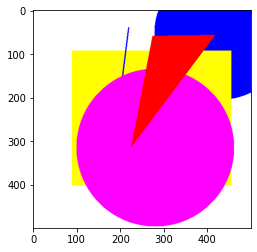

In [6]:
generated_image = generate_random_image(500, 500)
plt.imshow(cv2.cvtColor(generated_image, cv2.COLOR_BGR2RGB))

Above you should see a black square. As a first step, let's try to make it
white.

Take a look at the `generate_random_image` function. You will see that we are
using *Numpy* function `zeros` that is creating an array of a given shape. In
our case, the shape will be `(height, width, 3)` - the last dimension is used for
color-coding. As we are filling an array with zeros, the resulting image is
black.

In order to make numpy arrays compatible with *OpenCV*, we're setting
`dtype=np.uint8`.

Read about *Numpy*'s
[full function](https://numpy.org/doc/1.18/reference/generated/numpy.full.html)
and use it to create an image filled with the white color (`(255, 255, 255)`).


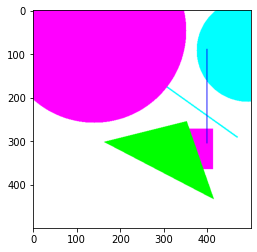

In [7]:
generated_image = generate_random_image(500, 500)
plt.imshow(cv2.cvtColor(generated_image, cv2.COLOR_BGR2RGB))

After applying changes to the `generate_random_image` file you should see
a white image after running the line above. Now let's work on shapes.

Read about
[`randint`](https://numpy.org/doc/1.18/reference/random/generated/numpy.random.randint.html)
and
[`choice`](https://numpy.org/doc/1.18/reference/random/generated/numpy.random.choice.html)
functions and use them to generate a random list from `AVAILABLE_SHAPES_DICT`
dict values.

In [8]:
from utils.test_images_generator.generator_config import AVAILABLE_SHAPES_DICT
AVAILABLE_SHAPES_DICT

{'LINE': 'LINE',
 'TRIANGLE': 'TRIANGLE',
 'RECTANGLE': 'RECTANGLE',
 'CIRCLE': 'CIRCLE'}

First, pick a random integer between `5` and `10` using `randint` function and
generate a list of this length filled with `AVAILABLE_SHAPES_DICT` values using
`choice`.

The generated image will be white as drawing functions are not
implemented yet.

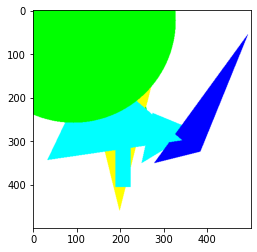

In [9]:
generated_image = generate_random_image(500, 500)
plt.imshow(cv2.cvtColor(generated_image, cv2.COLOR_BGR2RGB))

Let's modify `_draw_random_line`, `_draw_random_rectangle`, and
`_draw_random_circle` to make them draw shapes. We'll leave
`_draw_random_triangle` for later.

Read `OpenCV`'s [drawing functions tutorial](https://docs.opencv.org/master/dc/da5/tutorial_py_drawing_functions.html).

Remember that all of the required functions like `cv2.line` modify
the original image.

In `generator_utils` you will find two helper functions: `generate_random_color`
and `generate_random_image_points`.

Current `generate_random_color` version is returning black color every time, but we'll
tackle this later.


In [10]:
from utils.test_images_generator.generator_utils import generate_random_color, generate_random_image_points

In [11]:
generate_random_color()

(255, 0, 0)

In [12]:
generate_random_image_points(generated_image, 5)

[(12, 320), (156, 453), (217, 52), (484, 481), (126, 37)]

The code block below should display black shapes after implementing helper
function bodies.


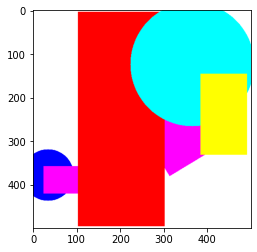

In [13]:
generated_image = generate_random_image(500, 500)
plt.imshow(cv2.cvtColor(generated_image, cv2.COLOR_BGR2RGB))

Let's fix `generate_random_color` function to make images more readable.
Again, use the `choice` function to pick a random color from
`AVAILABLE_COLORS_DICT`.

In [14]:
from utils.test_images_generator.generator_config import AVAILABLE_COLORS_DICT
AVAILABLE_COLORS_DICT

{'RED': (0, 0, 255),
 'GREEN': (0, 255, 0),
 'BLUE': (255, 0, 0),
 'YELLOW': (0, 255, 255),
 'PURPLE': (255, 0, 255),
 'CYAN': (255, 255, 0)}

In [15]:
generate_random_color()

(255, 0, 255)

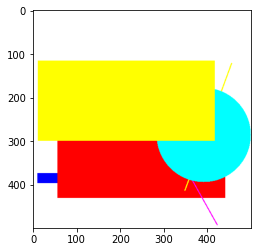

In [16]:
generated_image = generate_random_image(500, 500)
plt.imshow(cv2.cvtColor(generated_image, cv2.COLOR_BGR2RGB))

Much better. The last shape to tackle is a triangle. To generate it, use the
[`fillConvexPolly`](https://docs.opencv.org/master/d6/d6e/group__imgproc__draw.html#ga3069baf93b51565e386c8e591f8418e6)
function.

You will need to use
the [`reshape`](https://numpy.org/doc/1.18/reference/generated/numpy.reshape.html)
function on the list returned by `generate_random_image_points` to make it
compatible with `fillConvexPolly` - use `(-1, 1, 2)` as a shape attribute to
make it work.

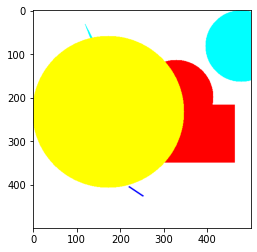

In [17]:
generated_image = generate_random_image(500, 500)
plt.imshow(cv2.cvtColor(generated_image, cv2.COLOR_BGR2RGB))

You can use now `generate_target_image` function from `generate_images`
to generate and save a new target image in the `assets` directory.

Let's move to random sources generation.

## 1.2 Generating source images

The general idea for the source images generation is to slice
`generate_target_image` results into small squares.

For most of the cases squares generated this way will be filled with one
color - either white image background or shape content. As we want
generated slices to be interesting, we will generate such flat images first
and then pick slices containing something more than a flat color.

In this chapter, we'll be working on `generate_patches_set` function
from `random_image_generator`. Currently, it only generates black squares
and stores them in the `assets` directory.

In [23]:
from utils.test_images_generator.generate_images import generate_patches_set, generate_target_image
from config import PATCH_SIZE

In [19]:
generate_patches_set('test', PATCH_SIZE, 300, 900, 500)

GENERATED 0300 OF 300 PATCHES

Let's start by generating flat color images. Again, the `full` function will
come in handy. Remember to add a white color to `AVAILABLE_COLORS_DICT` values.

In [20]:
generate_patches_set('test', PATCH_SIZE, 300, 900, 500)

GENERATED 0300 OF 300 PATCHES

To generate the rest of the patches, analyze main `generate_patches_set`
loop. Instead of assigning black square to `patch`, we'd like to select
a square from `generated_image` at `x, y` position of `patch_size` size.
Basic *Numpy*'s selecting methods will come in handy here.

You can see how we make sure that the selected image isn't just a flat
square.

The implemented method of generating source images is quite blunt, but it
serves its purpose.

After applying changes, `generate_patches_set` should generate nice, diverse
patches, starting with seven flat color squares.

In [21]:
generate_patches_set('test', PATCH_SIZE, 300, 900, 500)

GENERATED 0300 OF 300 PATCHES

Now we only have to generate our target image for further work

In [24]:
generate_target_image('test-target.jpg', 900, 500)